In [25]:
from dataclasses import dataclass
import glob

from IPython.display import HTML
import pandas as pd

from lib import work_dir
from lib import parametrization as par

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(font_scale=1.75)
color_map = sns.light_palette("green", as_cmap=True)


@dataclass
class ExperimentArguments:
    language: str
    transformation_name: str
    fuzzing_strategy: str
    subject_name: str


class CoveragePlotter:
    def __init__(self, args: ExperimentArguments):
        self._args = args

    def _create_path_patterns(self):
        shared_prefix = f"{work_dir}/coverage-reports"
        shared_suffix = f"{self._args.fuzzing_strategy}/{self._args.subject_name}"
        after_subdir = f"{self._args.language}/{self._args.transformation_name}"
        before_subdir = f"{self._args.language}/identity"
        after_pattern = f"{shared_prefix}/{after_subdir}/{shared_suffix}/**/coverage.csv"
        before_pattern = f"{shared_prefix}/{before_subdir}/{shared_suffix}/**/coverage.csv"
        return after_pattern, before_pattern

    def _find_matching_paths(self):
        after_pattern, before_pattern = self._create_path_patterns()
        after_paths = glob.glob(after_pattern, recursive=True)
        before_paths = glob.glob(before_pattern, recursive=True)
        return after_paths, before_paths

    def _load_coverages(self):
        after_paths, before_paths = self._find_matching_paths()
        after_coverages = [pd.read_csv(path, usecols=["filenum", "branch"]) for path in after_paths]
        before_coverages = [pd.read_csv(path, usecols=["filenum", "branch"]) for path in before_paths]
        return after_coverages, before_coverages

    def _concat_coverages(self):
        after_coverages, before_coverages = self._load_coverages()
        after_df = pd.concat(after_coverages)
        before_df = pd.concat(before_coverages)
        return after_df, before_df

    def _make_comparison_df(self):
        after_df, before_df = self._concat_coverages()
        after_df["transformation"] = self._args.transformation_name
        before_df["transformation"] = "identity"
        return pd.concat((after_df, before_df), sort=False, ignore_index=True)

    def _make_title(self):
        return f"Language {self._args.language}, Subject {self._args.subject_name}, Strategy {self._args.fuzzing_strategy}"

    def plot_mean_coverage_comparison(self):
        comparison_df = self._make_comparison_df()
        plt.figure(figsize=(20, 8))
        ax = sns.lineplot(data=comparison_df, x="filenum", y="branch", hue="transformation", style="transformation",
                          dashes=False, ci=95)  # , units="run", estimator=None)
        title = self._make_title()
        ax.set_title(title)
        ax.set_xlabel("Number of Files")
        ax.set_ylabel("Mean Branch Coverage")

    def plot_scatter_coverage_comparison(self):
        comparison_df = self._make_comparison_df()
        plt.figure(figsize=(20, 8))
        ax = sns.scatterplot(data=comparison_df, x="filenum", y="branch", hue="transformation", style="transformation")
        title = self._make_title()
        ax.set_title(title)
        ax.set_xlabel("Number of Files")
        ax.set_ylabel("Branch Coverage")
        
config = ExperimentArguments("json", "chomsky-normal-form", "recurrent-2-path-100", "argo")
plotter = CoveragePlotter(config)


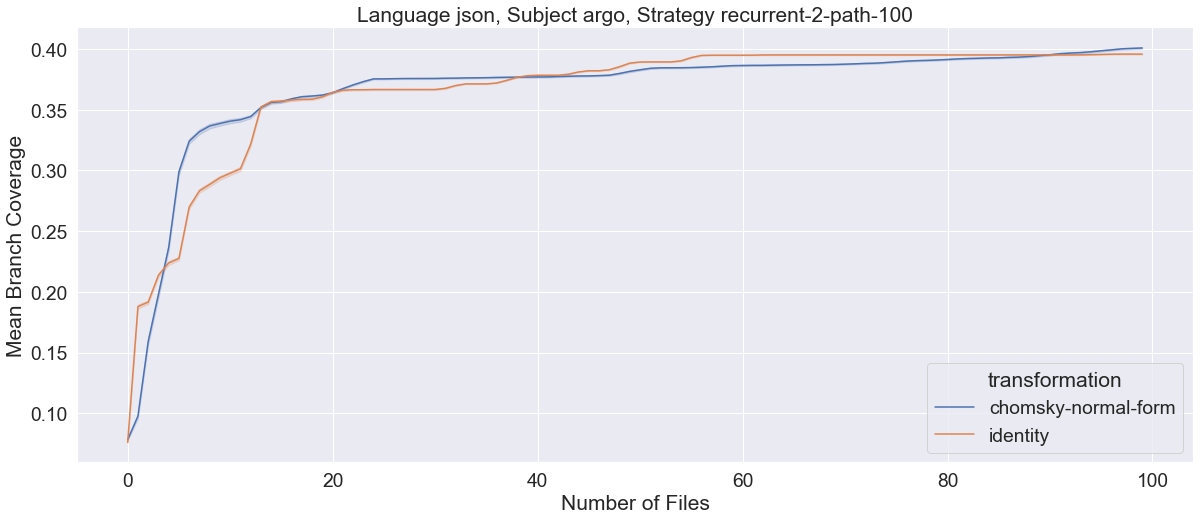

In [23]:
plotter.plot_mean_coverage_comparison()

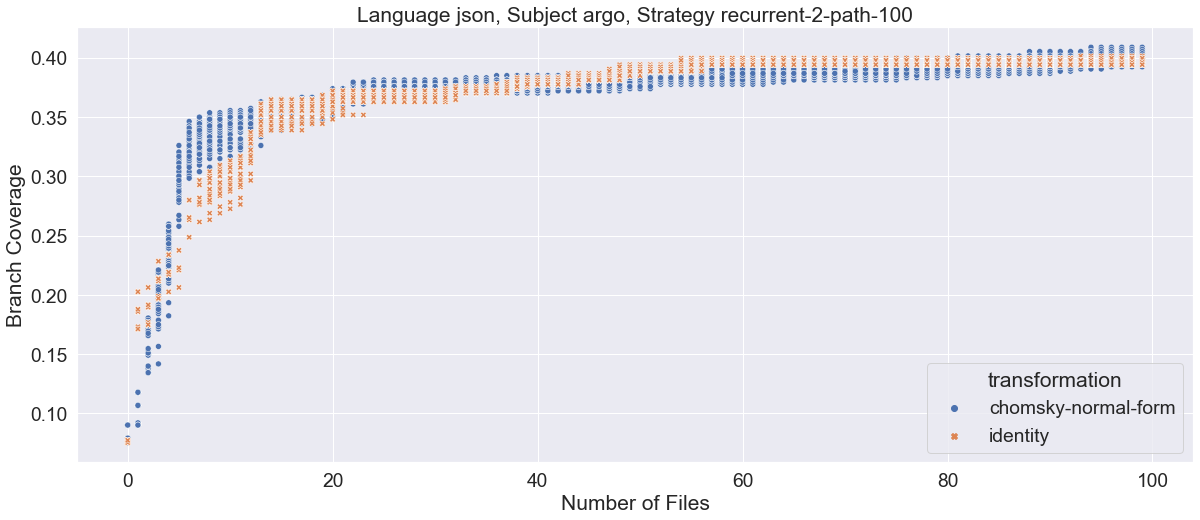

In [24]:
plotter.plot_scatter_coverage_comparison()